In [1]:
import os, random, sys, pathlib, zipfile, shutil, math
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

In [2]:
#@title Download dataset from Kaggle (upload your kaggle.json when prompted)
from google.colab import files

# Create .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Upload kaggle.json
print("Please upload your kaggle.json from Kaggle Account settings...")
uploaded = files.upload()  # choose kaggle.json

# Move and set permissions
if 'kaggle.json' in uploaded:
    shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 0o600)
else:
    raise RuntimeError("kaggle.json not uploaded.")

# Install Kaggle CLI (if needed) and download the dataset
!pip -q install -U kaggle
dataset = "paultimothymooney/chest-xray-pneumonia"
!kaggle datasets download -d $dataset -p /content

# Unzip
zip_path = "/content/chest-xray-pneumonia.zip"
extract_dir = "/content/chest_xray"
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content")
print("Extracted to:", extract_dir)

# Show folder structure
!find /content/chest_xray -maxdepth 2 -type d -print


Please upload your kaggle.json from Kaggle Account settings...


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:24<00:00, 156MB/s]
100% 2.29G/2.29G [00:24<00:00, 102MB/s]
Extracted to: /content/chest_xray
/content/chest_xray
/content/chest_xray/test
/content/chest_xray/test/NORMAL
/content/chest_xray/test/PNEUMONIA
/content/chest_xray/chest_xray
/content/chest_xray/chest_xray/test
/content/chest_xray/chest_xray/train
/content/chest_xray/chest_xray/val
/content/chest_xray/__MACOSX
/content/chest_xray/__MACOSX/chest_xray
/content/chest_xray/train
/content/chest_xray/train/NORMAL
/content/chest_xray/train/PNEUMONIA
/content/chest_xray/val
/content/chest_xray/val/NORMAL
/content/chest_xray/val/PNEUMONIA


In [3]:
from collections import Counter

def count_images(folder):
  counts={}
  for cls in sorted(os.listdir(folder)):
    print(f"cls is {cls}")
    cls_path= os.path.join(folder,cls)
    print(f"cls path: {cls_path}")
    if os.path.isdir(cls_path):
      n=len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png','.jpg','.jpeg'))])
      counts[cls]=n

  return counts
DATA_ROOT = "/content/chest_xray"
splits={}
for split in("train","val","test"):
  split_path= os.path.join(DATA_ROOT,split)
  splits[split]=count_images(split_path)
splits

cls is NORMAL
cls path: /content/chest_xray/train/NORMAL
cls is PNEUMONIA
cls path: /content/chest_xray/train/PNEUMONIA
cls is NORMAL
cls path: /content/chest_xray/val/NORMAL
cls is PNEUMONIA
cls path: /content/chest_xray/val/PNEUMONIA
cls is NORMAL
cls path: /content/chest_xray/test/NORMAL
cls is PNEUMONIA
cls path: /content/chest_xray/test/PNEUMONIA


{'train': {'NORMAL': 1341, 'PNEUMONIA': 3875},
 'val': {'NORMAL': 8, 'PNEUMONIA': 8},
 'test': {'NORMAL': 234, 'PNEUMONIA': 390}}

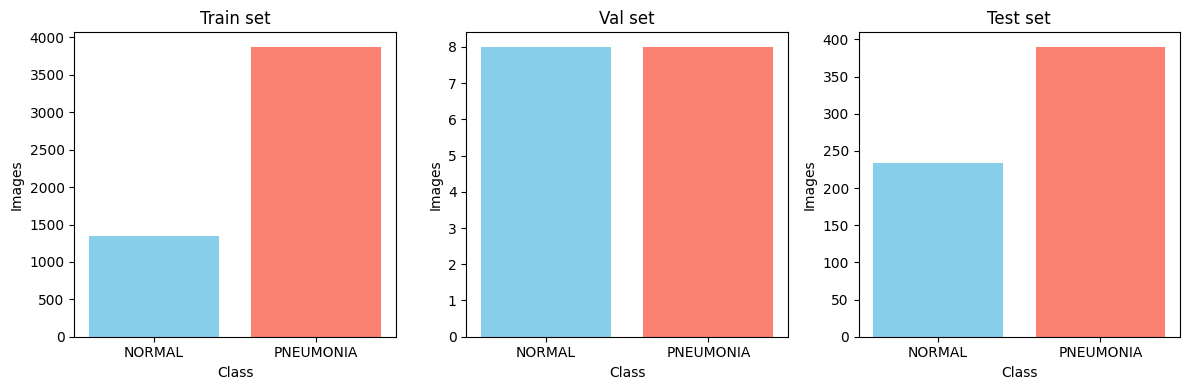

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))  # wide figure for 3 plots

for i, (split, counts) in enumerate(splits.items()):

    plt.subplot(1, 3, i+1)
    plt.bar(counts.keys(), counts.values(), color=['skyblue', 'salmon'])
    plt.title(f"{split.capitalize()} set")
    plt.xlabel("Class")
    plt.ylabel("Images")

plt.tight_layout()
plt.show()


classes: ['NORMAL', 'PNEUMONIA']
Classes: ['NORMAL', 'PNEUMONIA']
files: ['/content/chest_xray/train/NORMAL/NORMAL2-IM-0408-0001.jpeg', '/content/chest_xray/train/NORMAL/IM-0577-0001.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-0828-0001.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-0585-0001.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-0485-0001.jpeg', '/content/chest_xray/train/NORMAL/IM-0220-0001.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-1294-0001-0001.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-1025-0001.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-0402-0001.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-0913-0001.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-1220-0001.jpeg', '/content/chest_xray/train/NORMAL/IM-0256-0001.jpeg', '/content/chest_xray/train/NORMAL/IM-0395-0001.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-0456-0001.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-0419-0001.jpeg', '/content/chest_xray/tr

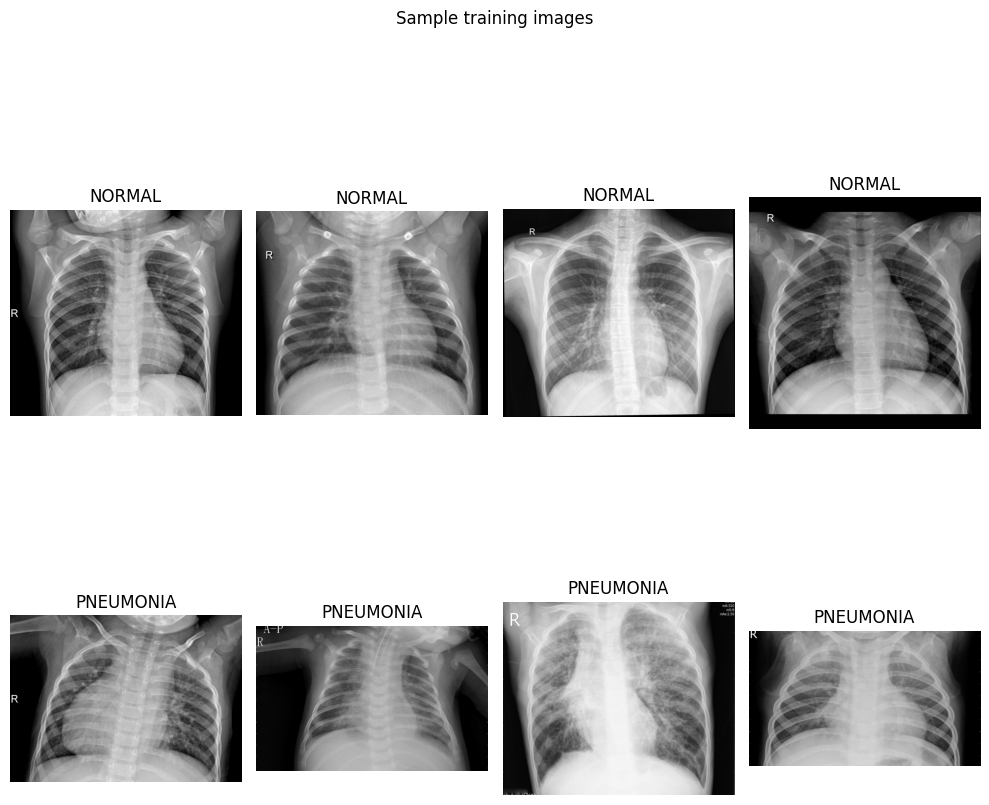

In [5]:
#@title Show sample images from both classes (train)
import matplotlib.pyplot as plt
import glob
classes = sorted(os.listdir(os.path.join(DATA_ROOT, "train")))
print(f"classes: {classes}")
classes = [c for c in classes if os.path.isdir(os.path.join(DATA_ROOT, "train", c))]# to take only the folders and add the class to the path
print("Classes:", classes)

n_per_class = 4
plt.figure(figsize=(10, 10))
for r, cls in enumerate(classes):

    files = glob.glob(os.path.join(DATA_ROOT, "train", cls, "*"))#search for the pattern *
    print(f"files: {files}")
    files = [f for f in files if f.lower().endswith(('.png','.jpg','.jpeg'))]
    for c in range(n_per_class):
        idx = r*n_per_class + c + 1
        plt.subplot(len(classes), n_per_class, idx)
        img = plt.imread(files[c])
        plt.imshow(img, cmap='gray')
        plt.title(cls)
        plt.axis('off')
plt.suptitle("Sample training images")
plt.tight_layout()
plt.show()


In [6]:
#data preprocessing

IMG_SIZE=(224,224)
BATCH_SIZE=32
AUTO_TUNE=tf.data.AUTOTUNE

train_dir= os.path.join(DATA_ROOT,"train")
val_dir= os.path.join(DATA_ROOT,"val")
test_dir= os.path.join(DATA_ROOT,"test")

train_ds=tf.keras.utils.image_dataset_from_directory(
    train_dir,label_mode="int",image_size=IMG_SIZE,batch_size=BATCH_SIZE,shuffle=True,seed=SEED)

val_ds=tf.keras.utils.image_dataset_from_directory(
    val_dir,label_mode="int",image_size=IMG_SIZE,batch_size=BATCH_SIZE,shuffle=True)


test_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,label_mode="int",image_size=IMG_SIZE,batch_size=BATCH_SIZE,shuffle=True)


class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)


normalization=tf.keras.layers.Rescaling(1./255)

data_augmentation=tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomTranslation(0.05,0.05)
])

train_ds= train_ds.map(lambda x,y:(normalization(x),y),num_parallel_calls=AUTO_TUNE)
val_ds   = val_ds.map(lambda x,y: (normalization(x), y),   num_parallel_calls=AUTO_TUNE)
test_ds  = test_ds.map(lambda x,y: (normalization(x), y),  num_parallel_calls=AUTO_TUNE)

train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTO_TUNE)
val_ds   = val_ds.cache().prefetch(AUTO_TUNE)
test_ds  = test_ds.cache().prefetch(AUTO_TUNE)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Class names: ['NORMAL', 'PNEUMONIA']


In [7]:
import tensorflow as tf

from tensorflow.keras import models,layers,optimizers

IMG_SIZE=(224,224)



def build_cnn_sequential(input_shape=IMG_SIZE+(3,)):
  model=models.Sequential()
  model.add(layers.Input(shape=input_shape))
  model.add(data_augmentation)
  model.add(layers.Conv2D(32,3,activation='relu',padding='same'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(64,3,activation='relu',padding='same'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(128,3,activation='relu',padding='same'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(128,3,activation='relu',padding='same'))
  model.add(layers.Conv2D(256,3,activation='relu',padding='same'))
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(1,activation='sigmoid',dtype='float32'))

  model.compile(
      optimizer=optimizers.Adam(learning_rate=1e-3),
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
  return model

cnn=build_cnn_sequential()
cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,257 (2.05 MB)

 Trainable params: 536,257 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras import callbacks

EPOCHS = 20
CKPT_PATH = "/content/cnn_best.keras"  # or any path you like

cb = [
    callbacks.ModelCheckpoint(
        filepath=CKPT_PATH,
        monitor="val_loss",
        mode="min",            # "min" because lower val_loss is better
        save_best_only=True,   # overwrite only when val_loss improves
        save_weights_only=False,  # keep full model so you can load directly
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6
    ),
]

history = cnn.fit(   # or cnn_seq.fit(...) if that's your model variable
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cb,
    verbose=1
)


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7325 - loss: 0.6000
Epoch 1: val_loss improved from inf to 0.66231, saving model to /content/cnn_best.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 60ms/step - accuracy: 0.7325 - loss: 0.5998 - val_accuracy: 0.6250 - val_loss: 0.6623 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7140 - loss: 0.5413
Epoch 2: val_loss improved from 0.66231 to 0.56017, saving model to /content/cnn_best.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.7142 - loss: 0.5411 - val_accuracy: 0.6875 - val_loss: 0.5602 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8207 - loss: 0.3677
Epoch 3: val_loss did not improve from 0.56017
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8208 - loss: 0.3675 - val_accuracy: 0.8125 - val_loss: 0.5627 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8609 - loss: 0.31

In [9]:


import tensorflow as tf
best = tf.keras.models.load_model("/content/cnn_best.keras")

best.evaluate(test_ds, verbose=1)





20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.8740 - loss: 0.3125


[0.3250817656517029, 0.8733974099159241]

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true, y_prob = [], []
for xb, yb in test_ds:
    p = best.predict(xb, verbose=0).ravel()
    y_prob.extend(p); y_true.extend(yb.numpy().astype(int))
y_true = np.array(y_true); y_pred = (np.array(y_prob) >= 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


              precision    recall  f1-score   support

      NORMAL     0.8744    0.7735    0.8209       234
   PNEUMONIA     0.8729    0.9333    0.9021       390

    accuracy                         0.8734       624
   macro avg     0.8736    0.8534    0.8615       624
weighted avg     0.8735    0.8734    0.8716       624



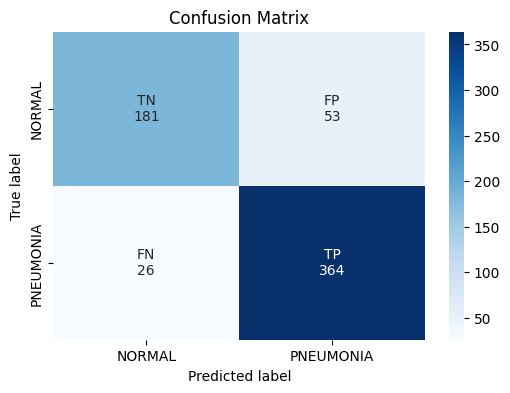

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define labels
labels = np.array([["TN", "FP"], ["FN", "TP"]])

# Combine counts with labels
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{labels[i,j]}\n{cm[i,j]}"

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=annot, fmt="", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

tf.keras.backend.clear_session()
# includetop=false we just want the feature extraction part from the network
#weights='imagenet': Load pretrained weights from the ImageNet dataset.

base = MobileNetV2(include_top=False, input_shape=IMG_SIZE + (3,), weights='imagenet')

'''
= False

Setting it to False means “freeze” the entire MobileNetV2 backbone.

During training, its weights will not be changed.

Only the new layers you add on top (like GlobalAveragePooling, Dense) will be trainable.
'''
base.trainable=False

tl_mnet = models.Sequential(name="mobilenetv2_frozen")
tl_mnet.add(layers.Input(shape=IMG_SIZE + (3,)))
tl_mnet.add(data_augmentation)


"""Lambda layer is really a translator:

Your dataset pipeline gives images in [0,1].

MobileNetV2 expects images in [-1,1].

This layer converts between those formats dynamically, every time a batch passes through."""

tl_mnet.add(layers.Lambda(lambda x: preprocess_input(x * 255.0), name="mnet_preproc"))

tl_mnet.add(base)
tl_mnet.add(layers.GlobalAveragePooling2D())
tl_mnet.add(layers.Dropout(0.3))
tl_mnet.add(layers.Dense(1, activation='sigmoid', dtype='float32'))

tl_mnet.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

tl_mnet.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_frozen"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnet_preproc (Lambda)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
from tensorflow.keras import callbacks

EPOCHS = 10   # we usually need fewer epochs when using a pretrained backbone
CKPT_PATH = "/content/mobilenetv2_frozen_best.keras"

cb = [
    callbacks.ModelCheckpoint(
        filepath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6
    ),
]

history_tl = tl_mnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cb,
    verbose=1
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9037 - loss: 0.2599
Epoch 1: val_loss improved from inf to 0.72574, saving model to /content/mobilenetv2_frozen_best.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9037 - loss: 0.2599 - val_accuracy: 0.5625 - val_loss: 0.7257 - learning_rate: 5.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8978 - loss: 0.2574
Epoch 2: val_loss did not improve from 0.72574
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8978 - loss: 0.2574 - val_accuracy: 0.5625 - val_loss: 0.7779 - learning_rate: 5.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9046 - loss: 0.2499
Epoch 3: val_loss did not improve from 0.72574
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9046 - loss: 0.2498 - val_accuracy: 0.5625 - val_loss: 0.7281 - learning_rate: 5.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9043 - loss: 0.2405
Epoch 4: val_loss

              precision    recall  f1-score   support

      NORMAL     1.0000    0.1496    0.2602       234
   PNEUMONIA     0.6621    1.0000    0.7967       390

    accuracy                         0.6811       624
   macro avg     0.8311    0.5748    0.5285       624
weighted avg     0.7888    0.6811    0.5955       624



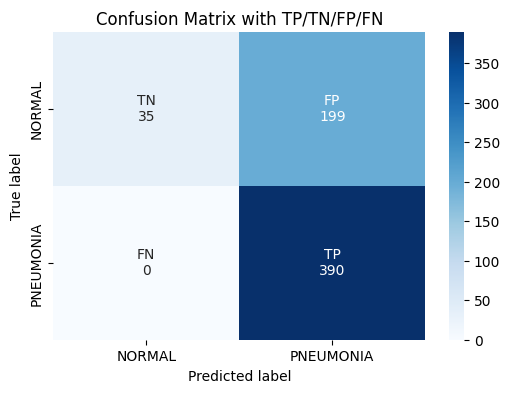

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluate predictions
y_true, y_prob = [], []
for xb, yb in test_ds:
    p = tl_mnet.predict(xb, verbose=0).ravel()   # use cnn or tl_mnet depending on model
    y_prob.extend(p)
    y_true.extend(yb.numpy().astype(int))

y_true = np.array(y_true)
y_pred = (np.array(y_prob) >= 0.5).astype(int)

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# TP/TN/FP/FN labels for binary classification
labels = np.array([["TN", "FP"], ["FN", "TP"]])
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{labels[i,j]}\n{cm[i,j]}"

# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=annot, fmt="", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix with TP/TN/FP/FN")
plt.show()
